<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Deployment

## Which files constitute a "model"?

We make a trained network useful by removing it from its training environment and "deploying" it into an application. Start where we left off in DIGITS.

DIGITS places the files we need to deploy in a directory that can either be downloaded or just pointed to. Since we're going to be deploying our model on the same server where it was trained, we can just point to the folder path that DIGITS generates.

### <a href="/digits">Open DIGITS</a>.

From DIGITS home page, select the model that we named "Dogs vs. Cats".

DIGITS' "Job Page" for the model is what you see as soon as you create the model, when it is training, and/or if you select the model under DIGITS' "model" tab. The Job Directory is in the top left.

![](images/ModelJobView.PNG)

**Copy the job directory (highlighted above) and replace ##FIXME## in the code block below. Once you've copied the directory, execute the cell (Shift+Enter) to store it to the variable <code>MODEL_JOB_DIR</code>**

In [1]:
MODEL_JOB_DIR = '/dli/data/digits/20180301-185638-e918'  ## Remember to set this to be the job directory for your model
!ls $MODEL_JOB_DIR

caffe_output.log   snapshot_iter_735.caffemodel   status.pickle
deploy.prototxt    snapshot_iter_735.solverstate  train_val.prototxt
original.prototxt  solver.prototxt


Assuming you copied and pasted well, you will see a list of all files in that directory. If the following instructions do not match what you're seeing, check the copy/paste directions.

Again, our "model" consists of two files: the architecture and the weights. 

The architecture is the file called ```deploy.prototxt``` and the weights are in the most recent snapshot file ```snapshot_iter_#.caffemodel.```In this case, snapshot number 735 contains the weights learned after all 5 epochs.

In [2]:
ARCHITECTURE = MODEL_JOB_DIR + '/' + 'deploy.prototxt'
WEIGHTS = MODEL_JOB_DIR + '/' + 'snapshot_iter_735.caffemodel'
print ("Filepath to Architecture = " + ARCHITECTURE)
print("Filepath to weights = "+ WEIGHTS)

Filepath to Architecture = /dli/data/digits/20180301-185638-e918/deploy.prototxt
Filepath to weights = /dli/data/digits/20180301-185638-e918/snapshot_iter_735.caffemodel


Next, we need to make sure that the program that we're building can both read and process those files. For this basic type of deployment, we'll need to install (or include) the framework that they were written in to be able to interpret them. We'll learn to deploy to environments that don't require installing the framework later in this course. We'll also need to use the GPU to take advantage of parallel processing. Again, our model consists of hundreds of thousands of operations that can be largely accelerated through parallelization. 

In [3]:
import caffe
caffe.set_mode_gpu()

Next, we'll create a "Classifier" object called "net". The more common the workflow, the easier existing tools will make your project. In this case, image classification is very common, so this next code block simply takes your architecture file and weights file and a bit about the data and makes common actions easy. 

In [4]:
# Initialize the Caffe model using the model trained in DIGITS
net = caffe.Classifier(ARCHITECTURE, WEIGHTS,  
                       channel_swap =(2, 1, 0), #Color images have three channels, Red, Green, and Blue.
                       raw_scale=255) #Each pixel value is a number between 0 and 255
                       #Each "channel" of our images are 256 x 256 

The Classifier class includes a method called "predict", which takes an input of an image as defined above and generates an output of the likelihood of the image belonging to each category.


## Creating an Expected Input: Preprocessing

To start with something easy, let's attempt to correctly classify a labeled image from the dataset. We can load the image and view it by running the cell below.

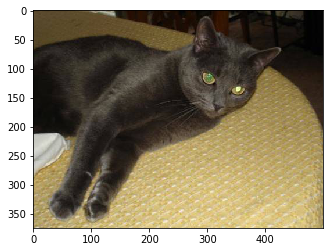

In [5]:
import matplotlib.pyplot as plt #matplotlib.pyplot allows us to visualize results
input_image= caffe.io.load_image('/dli/data/dogscats/train/cats/cat.10941.jpg')
plt.imshow(input_image)
plt.show()

While this is the image we have, it is not the 'input' the network expects. 

To prepare data for inference, we're going to follow one golden rule:<pre>Whatever was done prior to training must be done prior to inference</pre>

In the last section, you saw the files that were generated when DIGITS trained your model. In this section, we'll examine the files generated when DIGITS created your dataset.

The job directory for the **dataset** you just trained from is found by selecting the dataset from the model page "Dogs and Cats" and/or if you select the dataset under DIGITS' "dataset" tab. It's in the same place it was for the model, but should be a different number.

![](images/datasetjobdir.PNG)

Replace ##FIXME## with it and execute the code below to set DATA_JOB_DIR to the right filepath and examine what's inside:

In [7]:
DATA_JOB_DIR = '/dli/data/digits/20180222-165843-ada0'  ## Remember to set this to be the job directory for your model
!ls $DATA_JOB_DIR

create_train_db.log  labels.txt        mean.jpg       train.txt  val.txt
create_val_db.log    mean.binaryproto  status.pickle  train_db	 val_db


Again, there is more information here than you need (for now). There is an infinite amount that you *could* know about data science and data prep which will become clear as you work through a variety of deep learning problems. In this case, DIGITS did two steps prior to training. We call this *preprocessing.*

1) DIGITS resized the images to 256X256 color images  

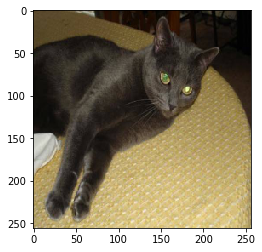

In [8]:
import cv2
input_image=cv2.resize(input_image, (256, 256), 0,0)
plt.imshow(input_image)
plt.show()

2) DIGITS *normalized* the images by subtracting the mean image from each image to reduce the computation necessary to train. 

Load the mean image and subtract it from the test image below:

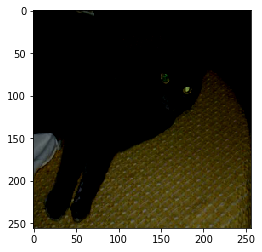

In [12]:
mean_image = caffe.io.load_image(DATA_JOB_DIR+'/mean.jpg')
ready_image = input_image-mean_image
plt.imshow(ready_image)
plt.show()

We've now taken data as it was and converted it into data that our network expects. Next, let's see what output our network creates.

## Forward Propagation: Using your model

This is what we care about. Let's take a look at the function:   
<code>prediction = net.predict([grid_square])</code>.

Like any [function](https://www.khanacademy.org/computing/computer-programming/programming#functions), <code>net.predict</code> passes an input, <code>ready_image</code>, and returns an output, <code>prediction</code>. Unlike other functions, this function isn't following a list of steps, instead, it's performing layer after layer of matrix math to transform an image into a vector of probabilities.  

Run the cell below to see the prediction from labeled the labeled data above.

In [13]:
# make prediction
prediction = net.predict([ready_image])
print prediction

[[ 0.70993775  0.29006225]]


Interesting, but doesn't contain all that much information. Our network took a normalized 256x256 color image and generated a vector of length 2.

## Generating a useful output: Postprocessing

At this point, we can really build whatever we want. Your only limit is your programming experience. Before getting creative, let's build something basic. This code will determine whether our network output a higher value for the likelihood of "dog" than it did for "cat." If so, it will display an image that would be appropriate if a dog approached our simulated doggy door. If not, the image represents what we'd want to happen if our network determined a cat was at the door.

Input image:


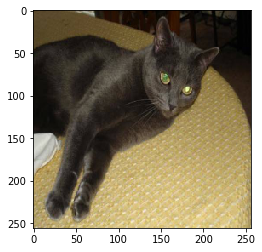

Output:
Sorry cat:( https://media.giphy.com/media/jb8aFEQk3tADS/giphy.gif


In [14]:
print("Input image:")
plt.imshow(input_image)
plt.show()

print("Output:")
if prediction.argmax()==0:
    print "Sorry cat:( https://media.giphy.com/media/jb8aFEQk3tADS/giphy.gif"
else:
    print "Welcome dog! https://www.flickr.com/photos/aidras/5379402670"

Here, now is everything in one place so you can test with an image that a doggy door might see.

Input Image:


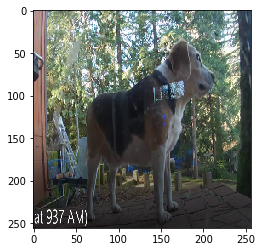

[[ 0.39924237  0.6007576 ]]
Output:
Welcome dog! https://www.flickr.com/photos/aidras/5379402670


In [15]:
##Create an input our network expects
input_image= caffe.io.load_image('/dli/data/fromnest.PNG')
input_image=cv2.resize(input_image, (256, 256), 0,0)
ready_image = input_image-mean_image
##Treat our network as a function that takes an input and generates an output
prediction = net.predict([ready_image])
print("Input Image:")
plt.imshow(input_image)
plt.show()
print(prediction)
##Create a useful output
print("Output:")
if prediction.argmax()==0:
    print "Sorry cat:( https://media.giphy.com/media/jb8aFEQk3tADS/giphy.gif"
else:
    print "Welcome dog! https://www.flickr.com/photos/aidras/5379402670"

Essentially, we've created a simulator for our doggy door challenge. We've created an application that takes an input from a camera, converts it to a data type our network expects, generates an output, and then converts that output into something useful to a user. 

You could see how you might easily have a positive output control a motor in a doggy door. With regards to deep learning, you have what you need! To see what other images you can try in the code block above, <code>list</code> the test images (images that weren't used for training) can be found by running the command below. Expect some of these images to output the wrong classification. Test them until you're satisfied and then continue in the course to find out how to improve performance!

In [16]:
!ls /dli/data/dogscats/test

1.jpg	   11605.jpg  1963.jpg	3570.jpg  5178.jpg  6786.jpg  8393.jpg
10.jpg	   11606.jpg  1964.jpg	3571.jpg  5179.jpg  6787.jpg  8394.jpg
100.jpg    11607.jpg  1965.jpg	3572.jpg  518.jpg   6788.jpg  8395.jpg
1000.jpg   11608.jpg  1966.jpg	3573.jpg  5180.jpg  6789.jpg  8396.jpg
10000.jpg  11609.jpg  1967.jpg	3574.jpg  5181.jpg  679.jpg   8397.jpg
10001.jpg  1161.jpg   1968.jpg	3575.jpg  5182.jpg  6790.jpg  8398.jpg
10002.jpg  11610.jpg  1969.jpg	3576.jpg  5183.jpg  6791.jpg  8399.jpg
10003.jpg  11611.jpg  197.jpg	3577.jpg  5184.jpg  6792.jpg  84.jpg
10004.jpg  11612.jpg  1970.jpg	3578.jpg  5185.jpg  6793.jpg  840.jpg
10005.jpg  11613.jpg  1971.jpg	3579.jpg  5186.jpg  6794.jpg  8400.jpg
10006.jpg  11614.jpg  1972.jpg	358.jpg   5187.jpg  6795.jpg  8401.jpg
10007.jpg  11615.jpg  1973.jpg	3580.jpg  5188.jpg  6796.jpg  8402.jpg
10008.jpg  11616.jpg  1974.jpg	3581.jpg  5189.jpg  6797.jpg  8403.jpg
10009.jpg  11617.jpg  1975.jpg	3582.jpg  519.jpg   6798.jpg  8404.jpg
1001.jpg   11618.jpg  1976.

## Putting it all together

Let's put this deployment process together to see how it might look outside of this Jupyter notebook. In the Python file at [pythondeployment.py](../../../../edit/tasks/task3/task/pythondeployment.py), you'll see the same code as above, but consolidated into one file. You'll use this approach during your end of course assessment, so take a look. Insert the filepath to a test image here to visualize it. 

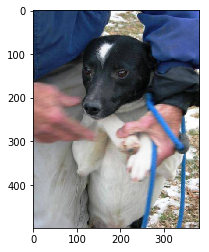

In [17]:
TEST_IMAGE = '/dli/data/dogscats/test/1.jpg'
display= caffe.io.load_image(TEST_IMAGE)
plt.imshow(display)
plt.show()

And then run our small python application with that image as input below. Ignore most of the output and scroll to the bottom. (Even errors and warnings are fine.)

In [18]:
!python pythondeployment.py $TEST_IMAGE 2>/dev/null

[[ 0.42844081  0.57155913]]
Output:
Welcome dog! https://www.flickr.com/photos/aidras/5379402670
None


<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>